In [1]:
# jupyter setup boilerplate
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from tqdm.auto import tqdm
from scipy.optimize import curve_fit

from qick import *

# for now, all the tProc v2 classes need to be individually imported (can't use qick.*)

# the main program class
from qick.asm_v2 import AveragerProgramV2
# for defining sweeps
from qick.asm_v2 import QickSweep1D

from qick_training import *

In [2]:
# soc = QickSoc(bitfile="/data/fw/2024-07-08_216_tprocv2r20_kidsim/qick_216.bit")
# soc = QickSoc(bitfile="/data/fw/2024-07-08_216_tprocv2r20_kidsim-dynROv1/qick_216.bit")

# soc = QickTrainingSoc(bitfile="/data/fw/2024-07-08_216_tprocv2r20_kidsim-dynROv1/qick_216.bit")
# soc = QickTrainingSoc(bitfile="/data/fw/2024-07-15_216_tprocv2r20_kidsim-dynROv1/qick_216.bit")
soc = QickTrainingSoc(bitfile="/data/fw/2024-07-15_216_tprocv2r20_kidsim-dynROv1-2/qick_216.bit")

# soc = QickTrainingSoc(bitfile="/data/QIS_SummerSchool_2024/ZCU216/demos_qce/firmware/qick_training.bit")

soccfg = soc
print(soccfg)

QICK running on ZCU216, software version 0.2.268

Firmware configuration (built Mon Jul 15 15:35:06 2024):

	Global clocks (MHz): tProcessor 614.400, RF reference 245.760

	1 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 16384 samples (1.667 us)
		fs=9830.400 MHz, fabric=614.400 MHz, 32-bit DDS, range=9830.400 MHz
		DAC tile 2, blk 0 is 0_230, on JHC3

	2 readout channels:
	0:	axis_dyn_readout_v1 - configured by tProc output 1
		fs=2457.600 MHz, decimated=307.200 MHz, 32-bit DDS, range=2457.600 MHz
		maxlen 16384 accumulated, 65536 decimated (213.333 us)
		triggered by tport 0, pin 0, feedback to tProc input 0
		ADC tile 2, blk 0 is 0_226, on JHC7
	1:	axis_readout_v2 - configured by PYNQ
		fs=2457.600 MHz, decimated=307.200 MHz, 32-bit DDS, range=2457.600 MHz
		maxlen 16384 accumulated, 65536 decimated (213.333 us)
		triggered by tport 1, pin 0, feedback to tProc input 1
		ADC tile 2, blk 1 is 1_226, on JHC8

	16 digital output pins:
	0:	PMOD0_0_LS
	1:	PMOD0_1_LS


In [3]:
RO_CH = 0

In [4]:
help(soc.config_resonator)

Help on method config_resonator in module qick_training:

config_resonator(simu_ch=0, q_adc=6, q_dac=0, f=500.0, df=2.0, dt=10.0, c0=0.99, c1=0.8, verbose=False) method of qick_training.QickTrainingSoc instance
    Configure the resonator simulator.
    
    The two qout values truncate the data at different points in the simulator.
    They affect both the simulator gain and its dynamic range.
    Smaller values mean more gain, but you might saturate something and your decimated traces will look like garbage.
    The default values were chosen to avoid saturation at max pulse power (i.e. a gain-1 const pulse).
    
    Parameters
    ----------
    simu_ch : int
        index of the simulator you want to configure
    q_adc : int
        number of bits to truncate at simulator input
        this basically sets the input's dynamic range
    q_dac : int
        number of bits to truncate at simulator output
        this basically sets the output power
    f : float
        resting frequ

In [5]:
soc.config_resonator(verbose=True)

SimuChain: f = 500.0 MHz, fd = -114.39999999999998 MHz, k = 232, fdds = 0.8000000000000114 MHz
AxisKidsimV3: sel        = resonator
AxisKidsimV3: channel    = 232
AxisKidsimV3: lane       = 0
AxisKidsimV3: punct_id   = 29
AxisKidsimV3: iir_c0     = 0.99
AxisKidsimV3: iir_c1     = 0.8
AxisKidsimV3: iir_g      = 0.9045226130653267
AxisKidsimV3: dds_freq   = 0.8000000000000114
AxisKidsimV3: dds_wait   = 95
AxisKidsimV3: sweep_freq = 2.0
AxisKidsimV3: sweep_time = 10.0
AxisKidsimV3: nstep      = 1
freq = 5461, bval = 13653, slope = 13653, steps = 1, wait = 95
c0 = 32440, c1 = 26214, g = 29639
sel = 0, punct_id = 29, addr = 0


In [6]:
# crank up the logging (optional)
import logging
# logging.basicConfig(level=logging.DEBUG, force=True)
# logging.basicConfig(level=logging.INFO, force=True, format='%(levelname)-8s [%(filename)s:%(lineno)d] %(message)s')
# logging.basicConfig(level=logging.DEBUG, force=True, format='%(levelname)-8s [%(filename)s:%(lineno)d] %(message)s')
logging.basicConfig(level=logging.WARNING, force=True)


In [7]:
# for i in range(0,8):
# #     print(soccfg['tprocs'][0]['output_pins'][4+i])
#     soccfg['tprocs'][0]['output_pins'][4+i] = ('output', 7, 12+i, 'Resonator %d'%(i))
soccfg['tprocs'][0]['output_pins']

[('dport', 1, 0, 'PMOD0_0_LS'),
 ('dport', 1, 1, 'PMOD0_1_LS'),
 ('dport', 1, 2, 'PMOD0_2_LS'),
 ('dport', 1, 3, 'PMOD0_3_LS'),
 ('dport', 1, 4, 'PMOD0_4_LS'),
 ('dport', 1, 5, 'PMOD0_5_LS'),
 ('dport', 1, 6, 'PMOD0_6_LS'),
 ('dport', 1, 7, 'PMOD0_7_LS'),
 ('dport', 0, 0, 'Resonator 0'),
 ('dport', 0, 1, 'Resonator 1'),
 ('dport', 0, 2, 'Resonator 2'),
 ('dport', 0, 3, 'Resonator 3'),
 ('dport', 0, 4, 'Resonator 4'),
 ('dport', 0, 5, 'Resonator 5'),
 ('dport', 0, 6, 'Resonator 6'),
 ('dport', 0, 7, 'Resonator 7')]

In [8]:
# help(soc.axis_kidsim_v3_0)
# soc.axis_kidsim_v3_0.L

In [9]:
# soccfg['tprocs'][0]['output_pins']
# soccfg['dacs']
# soccfg['adcs']
# soccfg._cfg


In [10]:
# simu.qout(3)
# simu.synthesis.qout(1)


In [11]:
# soc.axis_pfbs_pr_4x256_v1_0

In [12]:
# soc.rf.set_nyquist('30', 1)

In [13]:
# soc.axis_pfbs_pr_4x256_v1_0.qout_reg = 0

In [14]:
# soc.axis_pfba_pr_4x256_v1_0.qout_reg = 0

In [15]:
# soc.axis_kidsim_v3_0

In [16]:
# soccfg['simu']
# simu.fr
# simu.analysis.fr
# simu.synthesis.fr

In [17]:
# simu.qout(0)

In [18]:
# for f in tqdm(np.linspace(100,1200,30)):
#     cfg = {'sel':'resonator', 'freq':f,'sweep_time':1,'dds_wait':1}
#     simu.set_resonator(cfg)
# #     config['freq'] = f
# #     prog = PeriodicProgram(soccfg, reps=1, final_delay=10.0, cfg=config)
# #     prog.run_rounds(soc, progress=False)
#     time.sleep(1)

In [19]:
# simu.analysis.dict
# simu.synthesis.dict

In [20]:
# soc.axis_kidsim_v3_0.DF_DDS/1e6

  0%|          | 0/1 [00:00<?, ?it/s]

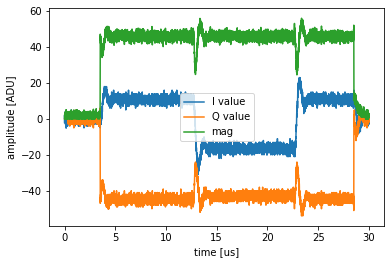

In [21]:
class ResTestProgram(AveragerProgramV2):
    def initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=cfg['nqz'])
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])

        self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['freq'], gen_ch=gen_ch)

        self.add_pulse(ch=gen_ch, name="mypulse", ro_ch=ro_ch, 
                       style="const", 
#                        mode='periodic',
                       freq=cfg['freq'], 
                       length=cfg['pulse_len'],
                       phase=cfg['phase'],
                       gain=cfg['gain'], 
                      )
        
        # trigger the resonator and the DDR4 buffer
        self.delay(1)
#         self.trigger(ddr4=True, t=0)
        self.delay(1)
        
    def body(self, cfg):

        # if you delay the config by too long, you can see the readout get reconfigured in the middle of your pulse
        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
        self.pulse(ch=cfg['gen_ch'], name="mypulse", t=0)
#         self.delay(1)
        if cfg['do_jump']:
            self.trigger(pins=list(range(8,16)), t=cfg['t_jump'])
        self.trigger(ros=[cfg['ro_ch']], ddr4=True, mr=True, pins=[0], t=cfg['trig_time'])
#         self.delay(1)

# do a sweep with 5 points and plot decimated
config = {'gen_ch': 0,
          'ro_ch': RO_CH,
          'freq': 499.0,
          'nqz': 1,
          'trig_time': 0.0,
          'do_jump' : True,
          't_jump' : 10,
          'ro_len': 30,
          'pulse_len': 25,
          'phase': 0,
          'gain': 0.1,
#           'gain': 0.05,
         }

prog = ResTestProgram(soccfg, reps=1, final_delay=10.0, cfg=config)


# Arm the buffers
soc.arm_mr(ch=RO_CH)
n_transfers = 100000 # each transfer (aka burst) is 256 decimated samples
soc.arm_ddr4(ch=RO_CH, nt=n_transfers)

iq_list = prog.acquire_decimated(soc, soft_avgs=1)
t = prog.get_time_axis(ro_index=0)

iq=iq_list[0]
plt.plot(t, iq[:,0], label="I value")
plt.plot(t, iq[:,1], label="Q value")
plt.plot(t, np.abs(iq.dot([1,1j])), label="mag")
plt.legend()
plt.ylabel("amplitude [ADU]")
plt.xlabel("time [us]");

In [22]:
# print(prog)

In [23]:
# class PeriodicProgram(AveragerProgramV2):
#     def initialize(self, cfg):
#         gen_ch = cfg['gen_ch']
        
#         self.declare_gen(ch=gen_ch, nqz=cfg['nqz'])

#         self.add_pulse(ch=gen_ch, name="mypulse", 
#                        style="const", 
#                        mode='periodic',
#                        freq=cfg['freq'], 
#                        length=cfg['pulse_len'],
#                        phase=cfg['phase'],
#                        gain=cfg['gain'], 
#                       )
        
#     def body(self, cfg):
# #         self.trigger(pins=list(range(8,16)), ddr4=True, t=0)

#         # if you delay the config by too long, you can see the readout get reconfigured in the middle of your pulse
#         self.pulse(ch=cfg['gen_ch'], name="mypulse", t=0)

# # do a sweep with 5 points and plot decimated
# config = {'gen_ch': 0,
#           'ro_ch': 1,
#           'freq': 599.0,
#           'nqz': 1,
#           'pulse_len': 100,
#           'phase': 0,
#           'gain': 0.02,
# #           'gain': 0.05
#          }

# cfg = {'sel':'resonator', 'freq':600,'sweep_time':1,'dds_wait':1}
# simu.set_resonator(cfg)

# for f in tqdm(range(900,1000)):
#     config['freq'] = f
#     prog = PeriodicProgram(soccfg, reps=1, final_delay=10.0, cfg=config)
#     prog.run_rounds(soc, progress=False)
#     time.sleep(0.1)

In [24]:
# for f in tqdm(range(100,1200)):
#     cfg = {'sel':'resonator', 'freq':f,'sweep_time':1,'dds_wait':1}
#     simu.set_resonator(cfg)
# #     config['freq'] = f
# #     prog = PeriodicProgram(soccfg, reps=1, final_delay=10.0, cfg=config)
# #     prog.run_rounds(soc, progress=False)
#     time.sleep(0.1)

In [25]:
# # simu.alloff()
# simu.qout(1)

In [26]:
# print(prog)
# for x in prog.macro_list:
#     print(x)
# for x in prog.prog_list:
#     print(x)

In [27]:
# iq_ddr4 = soc.get_ddr4(100)
# t = prog.get_time_axis_ddr4(0, iq_ddr4)

# plt.plot(t, iq_ddr4[:,0],label="I")
# plt.plot(t, iq_ddr4[:,1],label="Q")
# # plt.plot(np.abs(iq_ddr4.dot([1,1j])),label="mag")
# plt.xlabel("us")
# plt.legend();

In [28]:
# soc.clear_ddr4()

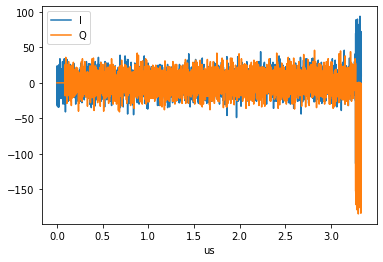

In [29]:
# look at the MR buffer just to see it works
iq_mr = soc.get_mr()
t = prog.get_time_axis_mr(0, iq_mr)
plt.plot(t, iq_mr[:,0],label="I")
plt.plot(t, iq_mr[:,1],label="Q")
plt.xlabel("us")
plt.legend();

In [30]:
# class ResetGensProgram(AveragerProgramV2):
#     def initialize(self, cfg):
#         gen_ch = cfg['gen_ch']
        
#         self.declare_gen(ch=gen_ch, nqz=cfg['nqz'])

#         self.add_pulse(ch=gen_ch, name="mypulse",
#                        style="const", 
#                        freq=0, 
#                        length=0.1,
#                        phase=0,
#                        gain=0, 
#                       )
        
#     def body(self, cfg):
#         self.pulse(ch=cfg['gen_ch'], name="mypulse", t=0)

# # do a sweep with 5 points and plot decimated
# config = {'gen_ch': 0,
#           'freq': 500.0,
#           'nqz': 1,
#          }

# prog = ResetGensProgram(soccfg, reps=1, final_delay=10.0, cfg=config)
# prog.run_rounds(soc)

In [31]:
# let's play some max-power pulses far from the resonance, to make sure we're not saturating the simulator
START_FREQ = 495
CAL_RANGE = 0.1
END_FREQ = 505

# START_FREQ = 100
# CAL_RANGE = 1
# END_FREQ = 2000

class FreqSweepProgram(AveragerProgramV2):
    def initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=cfg['nqz'])
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])

        self.add_loop("myloop", self.cfg["steps"])
        self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['freq'], gen_ch=gen_ch)

#         self.add_gauss(ch=gen_ch, name="ramp", sigma=cfg['ramp_len']/10, length=cfg['ramp_len'], even_length=True)
        self.add_pulse(ch=gen_ch, name="mypulse", ro_ch=ro_ch, 
#                        style="flat_top", 
                       style="const", 
#                        envelope="ramp",
                       freq=cfg['freq'], 
                       length=cfg['flat_len'],
                       phase=cfg['phase'],
                       gain=cfg['gain'], 
                      )
#         self.trigger(pins=list(range(8,16)),t=0)
        
    def body(self, cfg):
        # if you delay the config by too long, you can see the readout get reconfigured in the middle of your pulse
        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
        self.pulse(ch=cfg['gen_ch'], name="mypulse", t=0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])

# do a sweep with 5 points and plot decimated
config = {'steps': 5,
          'gen_ch': 0,
          'ro_ch': RO_CH,
          'freq': QickSweep1D("myloop", START_FREQ, START_FREQ+CAL_RANGE),
          'nqz': 1,
          'trig_time': 3.0,
          'ro_len': 12,
          'flat_len': 10.0,
          'ramp_len': 1.0,
          'phase': 0,
          'gain': 1.0,
         }

prog = FreqSweepProgram(soccfg, reps=1, final_delay=10.0, cfg=config)

iq_list = prog.acquire_decimated(soc, soft_avgs=1)
t = prog.get_time_axis(ro_index=0)

  0%|          | 0/1 [00:00<?, ?it/s]

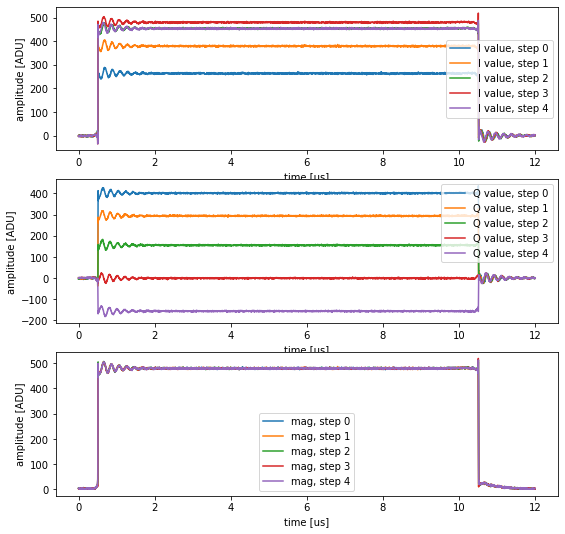

In [32]:
fig, axes = plt.subplots(3, 1, figsize=(9,9))
for ii, iq in enumerate(iq_list[0]):
    axes[0].plot(t, iq[:,0], label="I value, step %d"%(ii))
    axes[1].plot(t, iq[:,1], label="Q value, step %d"%(ii))
    axes[2].plot(t, np.abs(iq.dot([1,1j])), label="mag, step %d"%(ii))
for plot in axes:
    plot.legend()
    plot.set_ylabel("amplitude [ADU]")
    plot.set_xlabel("time [us]");

  0%|          | 0/100010 [00:00<?, ?it/s]

phase step (cycles): -1.3491862560194301e-05
relative delay -2.1007 us


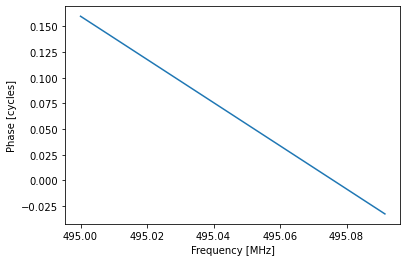

In [33]:
# config['steps']=100001
config['steps']=10001

prog = FreqSweepProgram(soccfg, reps=10, final_delay=1.0, cfg=config)
freqs = prog.get_pulse_param('myro', 'freq', as_array=True)
iq_list = prog.acquire(soc, soft_avgs=1, progress=True)
# plt.plot(np.angle(iq_list[0][0].dot([1,1j]), deg=True))

# plt.plot(iq_list[0][0,:,0], iq_list[0][0,:,1], '.')
# plt.ylabel("Q [ADU]")
# plt.xlabel("I [ADU]");

iq_complex = iq_list[0][0].dot([1,1j])
phases = np.unwrap(np.angle(iq_complex))/(2*np.pi)

plt.plot(freqs, phases)
plt.ylabel("Phase [cycles]")
plt.xlabel("Frequency [MHz]")

print("phase step (cycles):", phases[1]-phases[0])

a = np.vstack([freqs, np.ones_like(freqs)]).T
phase_delay = np.linalg.lstsq(a, phases, rcond=None)[0][0]
print("relative delay %.4f us"%(phase_delay))

  0%|          | 0/100010 [00:00<?, ?it/s]

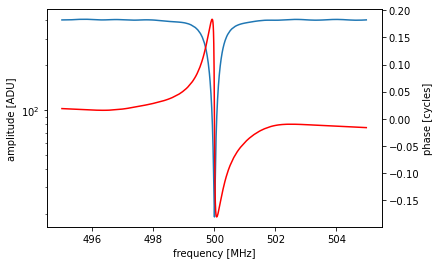

In [34]:
config['freq'] = QickSweep1D("myloop", START_FREQ, END_FREQ)
# config['freq'] = QickSweep1D("myloop", 490, 510)

config['steps'] = 10001
# freqs = np.linspace(START_FREQ, END_FREQ, config['steps'])

prog = FreqSweepProgram(soccfg, reps=10, final_delay=10.0, cfg=config)
freqs = prog.get_pulse_param('myro', 'freq', as_array=True)
iq_list = prog.acquire(soc, soft_avgs=1, progress=True)
iq_complex = iq_list[0][0].dot([1,1j])

iq_rotated = iq_complex*np.exp(-1j*freqs*2*np.pi*phase_delay)

# plt.plot(np.real(iq_rotated), np.imag(iq_rotated))
# plt.ylabel("Q [ADU]")
# plt.xlabel("I [ADU]");

# phases_corrected = np.unwrap(np.angle(iq_rotated))/(2*np.pi)
phases_corrected = np.angle(iq_rotated)/(2*np.pi)

fig, plot = plt.subplots()
plot.semilogy(freqs, np.abs(iq_rotated), label="amplitude")
ax2 = plot.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(freqs, phases_corrected, color='red', label='phase')

plot.set_ylabel("amplitude [ADU]")
plot.set_xlabel("frequency [MHz]")
ax2.set_ylabel("phase [cycles]");

pole-zero fit: [499.99934935   0.99018738   0.7967686  404.87513725]


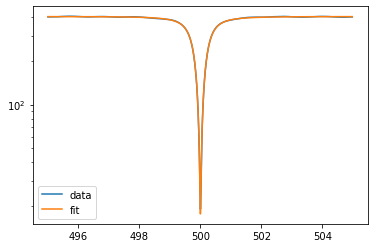

In [35]:
# fit a pole-zero function to the magnitude
# gives a good fit, though we clearly don't know how to normalize the parameters correctly
# we could do a complex fit, but don't need to

def polezero(f, f0, c0, c1, G):
    f_scale = 1.5 # this is probably related to the time interval used in the IIR or something
    z = np.exp(1j*f/f_scale)
    # leo applies an overall G0 = (1+c1)/(1+c0) which seems to normalize to 1 far from the resonance
    G0 = (1+c1)/(1+c0)
    return G*G0*np.abs((z-c0*np.exp(1j*f0/f_scale))/(z-c1*np.exp(1j*f0/f_scale)))

mags = np.abs(iq_rotated)
plt.semilogy(freqs, mags, label='data')

guess = [500, 0.9, 0.8, np.max(mags)]
popt, pcov = curve_fit(polezero, freqs, mags, maxfev = 100000, p0 = guess)
fit_polezero = polezero(freqs, *popt)
# plt.semilogy(freqs, polezero(freqs, *guess), label='guess')
plt.semilogy(freqs, fit_polezero, label='fit')
plt.legend()

print("pole-zero fit:", popt)

In [36]:
soc.config_resonator(c0=0.9, c1=0.3, verbose=True)

SimuChain: f = 500.0 MHz, fd = -114.39999999999998 MHz, k = 232, fdds = 0.8000000000000114 MHz
AxisKidsimV3: sel        = resonator
AxisKidsimV3: channel    = 232
AxisKidsimV3: lane       = 0
AxisKidsimV3: punct_id   = 29
AxisKidsimV3: iir_c0     = 0.9
AxisKidsimV3: iir_c1     = 0.3
AxisKidsimV3: iir_g      = 0.6842105263157895
AxisKidsimV3: dds_freq   = 0.8000000000000114
AxisKidsimV3: dds_wait   = 95
AxisKidsimV3: sweep_freq = 2.0
AxisKidsimV3: sweep_time = 10.0
AxisKidsimV3: nstep      = 1
freq = 5461, bval = 13653, slope = 13653, steps = 1, wait = 95
c0 = 29491, c1 = 9830, g = 22420
sel = 0, punct_id = 29, addr = 0


  0%|          | 0/1 [00:00<?, ?it/s]

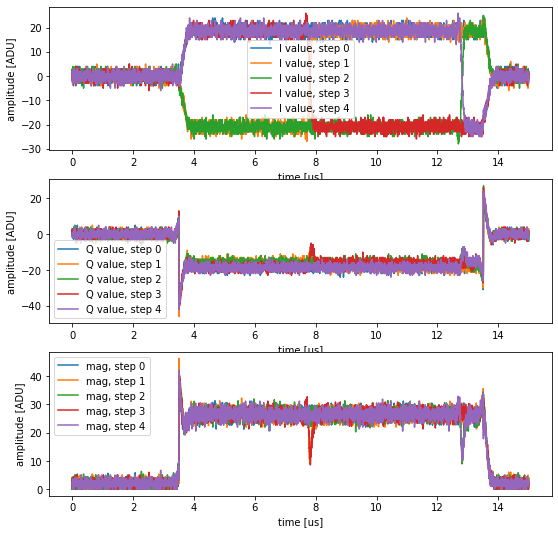

In [37]:
class T1Program(AveragerProgramV2):
    def initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=cfg['nqz'])
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])

        self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['freq'], gen_ch=gen_ch)

        self.add_pulse(ch=gen_ch, name="mypulse", ro_ch=ro_ch, 
                       style="const", 
#                        mode='periodic',
                       freq=cfg['freq'], 
                       length=cfg['pulse_len'],
                       phase=cfg['phase'],
                       gain=cfg['gain'], 
                      )
        
        self.add_loop("myloop", self.cfg["steps"])
        
        # configure the readout
        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
        # trigger the special buffers
        self.trigger(ddr4=True, mr=True, t=0)
        
    def body(self, cfg):
        if cfg['do_jump']:
            self.trigger(pins=list(range(8,16)), t=cfg['t_jump'])
            
        self.delay(10)
        self.pulse(ch=cfg['gen_ch'], name="mypulse", t=cfg['t_pulse'])
#         self.delay(1)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['t_ro'])
#         self.delay(1)

# do a sweep with 5 points and plot decimated
config = {'gen_ch': 0,
          'ro_ch': RO_CH,
          'freq': 499.0,
          'nqz': 1,
          't_pulse': 0.0,
          't_ro': 0.0,
          'do_jump' : True,
          't_jump' : QickSweep1D("myloop", 0.0, 20.0),
          'steps' : 5,
          'ro_len': 15,
          'pulse_len': 10,
          'phase': 0,
          'gain': 0.1,
#           'gain': 0.05,
         }

prog = T1Program(soccfg, reps=1, final_delay=10.0, cfg=config)


# Arm the buffers
soc.arm_mr(ch=RO_CH)
n_transfers = 100000 # each transfer (aka burst) is 256 decimated samples
soc.arm_ddr4(ch=RO_CH, nt=n_transfers)

iq_list = prog.acquire_decimated(soc, soft_avgs=1)
t = prog.get_time_axis(ro_index=0)

fig, axes = plt.subplots(3, 1, figsize=(9,9))
for ii, iq in enumerate(iq_list[0]):
    axes[0].plot(t, iq[:,0], label="I value, step %d"%(ii))
    axes[1].plot(t, iq[:,1], label="Q value, step %d"%(ii))
    axes[2].plot(t, np.abs(iq.dot([1,1j])), label="mag, step %d"%(ii))
for plot in axes:
    plot.legend()
    plot.set_ylabel("amplitude [ADU]")
    plot.set_xlabel("time [us]");

In [38]:
iq.shape

(4608, 2)

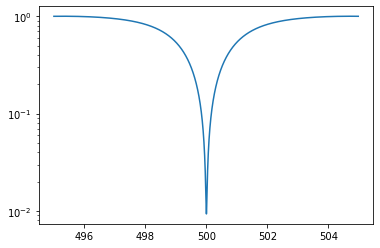

In [39]:
plt.semilogy(freqs, polezero(freqs, 500, 0.99, 0.3, 1.0))


In [40]:
# print(prog)

In [41]:
# # simu.enable(f=500, t=6.2, N=1, verbose=True)
# simu.enable(f=500, verbose=True)

In [42]:
# ###############################
# ### Resonator Configuration ###
# ###############################
# simu.qout(3)
# # simu.synthesis.qout(1)
# # Disable all resonators.
# simu.alloff()
# fr = 500
# res_jump_time = 6.2
# # res_jump_time = 60.2

# ### Resonator configuration. Note that some of these config parameters depend on each other, 
# ### so not every configuration is possible.
# cfg = {'sel' : 'resonator', 'freq' : fr}
# cfg['nstep'] = 1 # 3
# cfg['sweep_time'] = res_jump_time # should be a little longer than readout time (5 us)

# # cfg['iir_c0']=0.9
# # cfg['iir_c1']=0.9
# # cfg['sel'] = 'dds'

# simu.set_resonator(cfg, verbose=True)

NameError: name 'simu' is not defined

In [ ]:
# # full-speed gen, standard RO
# class SimpleSweepProgram(AveragerProgramV2):
#     def initialize(self, cfg):
#         ro_ch = cfg['ro_ch']
#         gen_ch = cfg['gen_ch']
        
#         self.declare_gen(ch=gen_ch, nqz=1)
#         self.declare_readout(ch=ro_ch, length=cfg['ro_len'], freq=cfg['freq'], gen_ch=gen_ch)

#         self.add_loop("myloop", self.cfg["steps"])

#         self.add_gauss(ch=gen_ch, name="ramp", sigma=cfg['ramp_len']/10, length=cfg['ramp_len'], even_length=True)
#         self.add_pulse(ch=gen_ch, name="mypulse", ro_ch=ro_ch, 
#                        style="flat_top", 
#                        envelope="ramp", 
#                        freq=cfg['freq'], 
#                        length=cfg['flat_len'],
#                        phase=cfg['phase'],
#                        gain=cfg['gain'], 
#                       )
        
#     def body(self, cfg):
#         self.pulse(ch=cfg['gen_ch'], name="mypulse", t=0)
#         self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])
        
# # do a sweep with 5 points and plot decimated
# config = {'steps': 5,
#           'gen_ch': 0,
#           'ro_ch': 0,
#           'freq': 2000,
#           'trig_time': 0.45,
#           'ro_len': 0.3,
#           'flat_len': 0.05,
#           'ramp_len': 0.2,
#           'phase': QickSweep1D("myloop", -360, 720),
#           'gain': QickSweep1D("myloop", 0.0, 1.0)
#          }

# prog = SimpleSweepProgram(soccfg, reps=1, final_delay=0.5, cfg=config)

# iq_list = prog.acquire_decimated(soc, soft_avgs=1)
# t = prog.get_time_axis(ro_index=0)

# for ii, iq in enumerate(iq_list[0]):
#     plt.plot(t, iq[:,0], label="I value, step %d"%(ii))
#     # plt.plot(iq[:,1], label="Q value, step %d"%(ii))
#     # plt.plot(np.abs(iq.dot([1,1j])), label="mag, step %d"%(ii))
# plt.legend()
# plt.ylabel("amplitude [ADU]")
# plt.xlabel("time [us]");

In [ ]:
# # fullspeed gen, new dynamic RO
# class SimpleSweepProgram2(AveragerProgramV2):
#     def initialize(self, cfg):
#         ro_ch = cfg['ro_ch']
#         gen_ch = cfg['gen_ch']
        
#         self.declare_gen(ch=gen_ch, nqz=cfg['nqz'])
#         self.declare_readout(ch=ro_ch, length=cfg['ro_len'])

#         self.add_loop("myloop", self.cfg["steps"])
#         self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['freq'], gen_ch=gen_ch)

#         self.add_gauss(ch=gen_ch, name="ramp", sigma=cfg['ramp_len']/10, length=cfg['ramp_len'], even_length=True)
#         self.add_pulse(ch=gen_ch, name="mypulse", ro_ch=ro_ch, 
#                        style="flat_top", 
#                        envelope="ramp", 
#                        freq=cfg['freq'], 
#                        length=cfg['flat_len'],
#                        phase=cfg['phase'],
#                        gain=cfg['gain'], 
#                       )

        
#         self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
        
#     def body(self, cfg):
#         self.pulse(ch=cfg['gen_ch'], name="mypulse", t=0)
#         self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])

In [ ]:
# # do a sweep with 5 points and plot decimated
# config = {'steps': 5,
#           'gen_ch': 0,
#           'ro_ch': 1,
#           'freq': 1500,
#           'nqz': 1,
#           'trig_time': 0.45,
#           'ro_len': 0.3,
#           'flat_len': 0.05,
#           'ramp_len': 0.2,
#           'phase': QickSweep1D("myloop", -360, 720),
#           'gain': QickSweep1D("myloop", 0.0, 1.0)
#          }

# prog = SimpleSweepProgram2(soccfg, reps=1, final_delay=0.5, cfg=config)

# iq_list = prog.acquire_decimated(soc, soft_avgs=1)
# t = prog.get_time_axis(ro_index=0)

# for ii, iq in enumerate(iq_list[0]):
#     plt.plot(t, iq[:,0], label="I value, step %d"%(ii))
#     # plt.plot(t, iq[:,1], label="Q value, step %d"%(ii))
#     # plt.plot(t, np.abs(iq.dot([1,1j])), label="mag, step %d"%(ii))
# plt.legend()
# plt.ylabel("amplitude [ADU]")
# plt.xlabel("time [us]");

In [ ]:
# # copied from 01 tprocv2 demo - dynamic readout has zero offset, as expected since it's a copy of readout_v2
# class TestProgram2(AveragerProgramV2):
#     def initialize(self, cfg):
#         for ch in cfg['ro_chs']:
#             confname = "myro%d" % (ch)
#             self.declare_readout(ch=ch, length=cfg['ro_len'])
    
#             self.add_readoutconfig(ch=ch, name=confname, freq=100)
#             self.send_readoutconfig(ch=ch, name=confname, t=0)
        
#     def body(self, cfg):
#         self.trigger(ros=cfg['ro_chs'],  t=0)

# config = {
#     'ro_chs': [1],
#     'ro_len': 10000.0,
#  }

# prog = TestProgram2(soccfg, reps=100, final_delay=0.5, cfg=config)

# iq_list = prog.acquire(soc, soft_avgs=1)
# print(iq_list)

# iq_raw = prog.get_raw()

# nch = len(prog.ro_chs)
# fig, axes = plt.subplots(2*nch, 1, figsize=(12,3*nch))
# for i, (ch, rocfg) in enumerate(prog.ro_chs.items()):
    
#     offset = soccfg['readouts'][ch]['iq_offset']
#     bins = np.linspace(offset-0.01, offset+0.01, 101)
#     nsamp = rocfg['length']
#     plot = axes[2*i]
#     plot.hist(iq_raw[i][:,0,0]/nsamp, bins=bins);
#     plot = axes[2*i+1]
#     plot.hist(iq_raw[i][:,0,1]/nsamp, bins=bins);